## 💘 Description

This notebook consists of several parts for echocardiography video processing:
- Load data and convert custom marks to torch Dataset and write YOLO files
- YOLO model

## Libraries and imports

In [ ]:
# installing necessary libraries

# YOLO
!pip -q install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.0 MB/s eta 0:00:00


In [ ]:
# system
import os
import re
import sys
import math
import json
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import seaborn as sns
import warnings
import shutil
import pandas as pd
warnings.filterwarnings("ignore")


# image read and write tools
from torchvision.io import read_image, ImageReadMode
from PIL import Image
from IPython.display import Image as show_image
import cv2

# torch tools
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler


# YOLO tools
import ultralytics
from ultralytics import YOLO


# set plot parameters
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
sns.set(style='darkgrid', font_scale=1.2)
plt.ion()

## Devices and Disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
torch.cuda.empty_cache()

## Global Variables

In [ ]:
SEED = torch.Generator().manual_seed(1001)
dataDirs = ['drive/MyDrive/Colab Notebooks/template/data/',
            'drive/MyDrive/Colab Notebooks/template/data_1/',
            'drive/MyDrive/Colab Notebooks/template/data_2/',
            'drive/MyDrive/Colab Notebooks/template/data_3/',
            'drive/MyDrive/Colab Notebooks/template/data_4/',
            'drive/MyDrive/Colab Notebooks/template/data_5/',
            'drive/MyDrive/Colab Notebooks/template/data_6/',
            'drive/MyDrive/Colab Notebooks/template/data_7/']
ann_files = [os.path.join(dataDirs[0], 'via_project_19Feb2024_19h9m.json'),
             os.path.join(dataDirs[1],'via_project_12Feb2024_22h22m.json'),
             os.path.join(dataDirs[2],'via_project_13May2024_13h9m(2).json'),
             os.path.join(dataDirs[3],'via_project_27May2024_12h44m.json'),
             os.path.join(dataDirs[4],'via_project_27May2024_13h52m.json'),
             os.path.join(dataDirs[5],'via_project_27May2024_12h44m.json'),
             os.path.join(dataDirs[6],'via_project_3Jun2024_10h31m.json'),
             os.path.join(dataDirs[7],'via_project_3Jun2024_11h54m.json')]

modelDir = 'drive/MyDrive/Colab Notebooks/template/models/'


## Annotations

There are instance segmentation masks for righr and left ventricle, light and left atrium, mitral valve, tricuspid valve and whole heart

In [ ]:
CLASSES_MASKS = {
    'LA': 1,
    'LV': 2,
    'RA': 3,
    'RV': 4,
    'MV': 5,
    'TV': 6
}

## Dataset Class

In [ ]:
class HeartSegmDataset(torch.utils.data.Dataset):

    def __init__(self, root, ann_path, attr, transforms, cropper=False):
        self.root = root
        self.ann_path = ann_path
        self.attr = attr
        self.transforms = transforms
        self.ann = self.__get_ann__(self.ann_path)
        self.ann_keys = list(self.ann.keys())
        self.cropper = cropper

    def __get_ann__(self, path: str) -> dict:
        with open(path) as fid:
            annotations = json.load(fid)
        annotations = annotations['_via_img_metadata']
        for k in list(annotations.keys()):
            k_new = k.split('.')[0] + '.png'
            annotations[k_new] = annotations.pop(k)
        return annotations

    def __get_poly__(self, image: torch.Tensor, regions: list, crop: bool):
        """get shape attributes for regions and transform labels and masks in yolo format"""
        result = []
        for r in regions:
            if len(r['region_attributes']) > 0 and re.sub(r'\W', '', r['region_attributes'][self.attr]) in CLASSES_MASKS:
                label = CLASSES_MASKS[re.sub(r'\W', '', r['region_attributes'][self.attr])]
                x = np.array(r['shape_attributes']['all_points_x'])
                y = np.array(r['shape_attributes']['all_points_y'])
                rel_x = x / image.shape[2]
                rel_y = y / image.shape[1]
                coord = list(np.stack([rel_x, rel_y], axis=1).flatten())
                result.append(f'{label-1} {" ".join(list(map(lambda x: str(round(x, 4)), coord)))}')

        return result


    def __getitem__(self, idx):

        img_path = os.path.join(self.root, self.ann[self.ann_keys[idx]]['filename'])
        try:
            img = Image.open(img_path).convert('L')
        except FileNotFoundError:
            print(f'no image with name {self.ann[self.ann_keys[idx]]["filename"]} in folder {self.root}')
            return []
        if self.cropper:
            pass
        if self.transforms is not None:
            img = self.transforms(img)
        try:
            yolo_strings = self.__get_poly__(img, self.ann[self.ann_keys[idx]]['regions'], self.cropper)
        except TypeError:
            print(f'empty elements in marks for image {self.ann[self.ann_keys[idx]]["filename"]} in annotations {self.ann_path}')
            return []
        if len(yolo_strings) != 6:
            print(f'incorrect marks for image {self.ann[self.ann_keys[idx]]["filename"]} in annotations {self.ann_path}')
            return []
        return img, yolo_strings

    def __len__(self):
        return len(self.ann_keys)

### DataSets and Transformers

In [ ]:
transforms = T.Compose([T.ToDtype(torch.float, scale=True),
                        T.ToTensor()])

data_0 = HeartSegmDataset(dataDirs[0], ann_files[0], 'Сердце', transforms=transforms, cropper=False)
data_1 = HeartSegmDataset(dataDirs[1], ann_files[1], 'Classes', transforms=transforms, cropper=False)
data_2 = HeartSegmDataset(dataDirs[2], ann_files[2], 'Classes', transforms=transforms, cropper=False)
data_3 = HeartSegmDataset(dataDirs[3], ann_files[3], 'heart', transforms=transforms, cropper=False)
data_4 = HeartSegmDataset(dataDirs[4], ann_files[4], 'heart', transforms=transforms, cropper=False)
data_5 = HeartSegmDataset(dataDirs[5], ann_files[5], 'heart', transforms=transforms, cropper=False)
data_6 = HeartSegmDataset(dataDirs[6], ann_files[6], 'heart', transforms=transforms, cropper=False)
data_7 = HeartSegmDataset(dataDirs[7], ann_files[7], 'heart', transforms=transforms, cropper=False)
data = ConcatDataset([data_0, data_1, data_2, data_3, data_4, data_5, data_6, data_7])

## YOLO

In [ ]:
ultralytics.checks()
y_model = YOLO('yolov8m-seg.pt')

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/78.2 GB disk)


100%|██████████| 52.4M/52.4M [00:00<00:00, 284MB/s]


### Transform dataset to YOLO format

In [ ]:
def save_yolo(data: torch.utils.data.dataset.Dataset, pth: str, mode: str):
    '''save tensors from torch dataset to disk,
    transforms masks to contours (relative coordinates)'''
    for i in tqdm(range(len(data)), desc=f'preparing YOLO {mode} folder'):
        content = data[i]
        if len(content) == 0:
            continue
        im_pth = os.path.join(pth, 'datasets', mode, 'images', f"img_{i}.png")
        torchvision.utils.save_image(content[0], im_pth)
        ann_pth = os.path.join(pth, 'datasets', mode, 'labels', f"img_{i}.txt")
        with open(ann_pth, 'w') as fid:
            for line in content[1]:
                fid.write(f'{line}\n')

In [ ]:
def prepare_yolo(data: torch.utils.data.dataset.Dataset, pth: str):
    '''prepare YOLO dataset, yaml file and folders'''
    shutil.rmtree(os.path.join(pth, 'datasets'), ignore_errors=True)
    os.mkdir(os.path.join(pth, 'datasets'))
    os.mkdir(os.path.join(pth, 'datasets', 'train'))
    os.mkdir(os.path.join(pth, 'datasets', 'val'))
    os.mkdir(os.path.join(pth, 'datasets', 'test'))
    os.mkdir(os.path.join(pth, 'datasets', 'train', 'images'))
    os.mkdir(os.path.join(pth, 'datasets', 'train', 'labels'))
    os.mkdir(os.path.join(pth, 'datasets', 'val', 'images'))
    os.mkdir(os.path.join(pth, 'datasets', 'val', 'labels'))
    os.mkdir(os.path.join(pth, 'datasets', 'test', 'images'))
    os.mkdir(os.path.join(pth, 'datasets', 'test', 'labels'))
    yaml_content = f'''
    train: train/images
    val: val/images
    test: test/images

    names: {list(CLASSES_MASKS.keys())}
    '''

    with open(os.path.join(pth, 'data.yaml'), 'w+') as fid:
        fid.write(yaml_content)
    train, valid, test = torch.utils.data.random_split(data, [.7, .2, .1], generator=SEED)
    save_yolo(train, pth, 'train')
    save_yolo(valid, pth, 'val')
    save_yolo(test, pth, 'test')

In [ ]:
prepare_yolo(data, '/content')

preparing YOLO train folder:   2%|▏         | 3/131 [00:01<01:11,  1.78it/s]

empty elements in marks for image 2.png in annotations drive/MyDrive/Colab Notebooks/template/data_2/via_project_13May2024_13h9m(2).json


preparing YOLO train folder:  11%|█         | 14/131 [00:07<00:59,  1.96it/s]

incorrect marks for image 17.png in annotations drive/MyDrive/Colab Notebooks/template/data_2/via_project_13May2024_13h9m(2).json


preparing YOLO train folder:  39%|███▉      | 51/131 [00:28<00:47,  1.67it/s]

no image with name s4.png in folder drive/MyDrive/Colab Notebooks/template/data_6/


preparing YOLO train folder:  55%|█████▍    | 72/131 [00:39<00:30,  1.95it/s]

incorrect marks for image d24.png in annotations drive/MyDrive/Colab Notebooks/template/data_4/via_project_27May2024_13h52m.json


preparing YOLO train folder:  58%|█████▊    | 76/131 [00:41<00:27,  1.98it/s]

incorrect marks for image 13 диаст.png in annotations drive/MyDrive/Colab Notebooks/template/data/via_project_19Feb2024_19h9m.json


preparing YOLO train folder:  86%|████████▋ | 113/131 [01:03<00:11,  1.58it/s]

no image with name s1.png in folder drive/MyDrive/Colab Notebooks/template/data_6/


preparing YOLO train folder:  98%|█████████▊| 129/131 [01:12<00:01,  1.81it/s]

incorrect marks for image 14.png in annotations drive/MyDrive/Colab Notebooks/template/data_2/via_project_13May2024_13h9m(2).json


preparing YOLO val folder:  41%|████      | 15/37 [00:08<00:11,  1.90it/s]

empty elements in marks for image 7.png in annotations drive/MyDrive/Colab Notebooks/template/data_2/via_project_13May2024_13h9m(2).json


preparing YOLO val folder:  76%|███████▌  | 28/37 [00:14<00:04,  2.05it/s]

incorrect marks for image 21.png in annotations drive/MyDrive/Colab Notebooks/template/data_2/via_project_13May2024_13h9m(2).json


preparing YOLO val folder:  92%|█████████▏| 34/37 [00:18<00:01,  1.82it/s]

empty elements in marks for image d22.png in annotations drive/MyDrive/Colab Notebooks/template/data_4/via_project_27May2024_13h52m.json


preparing YOLO test folder:  72%|███████▏  | 13/18 [00:06<00:02,  1.85it/s]

incorrect marks for image 1 диаст.png in annotations drive/MyDrive/Colab Notebooks/template/data_1/via_project_12Feb2024_22h22m.json


preparing YOLO test folder: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


In [ ]:
def test_yolo(pth: str, idx: int):
    '''test contours with relative coordinates'''
    path = os.path.join(pth, f'datasets/train/images/img_{idx}.png')
    l_path = os.path.join(pth, f'datasets/train/labels/img_{idx}.txt')
    image = Image.open(path).convert('L')
    image = tv_tensors.Image(image).permute(1, 2, 0).numpy()
    with open(l_path, 'r') as fid:
        content = fid.readlines()
    contours = []
    for c in content:
        clist = c.split(' ')
        label = int(clist[0])
        xy = list(map(float, clist[1:]))
        xx = []
        yy = []
        for j in range(0, len(xy), 2):
            xx.append(int(xy[j] * image.shape[1]))
            yy.append(int(xy[j + 1] * image.shape[0]))
        coord = torch.cat((torch.tensor(xx).unsqueeze(1), torch.tensor(yy).unsqueeze(1)), dim=1).unsqueeze(0).numpy()
        contours.append(coord)
    cv2.drawContours(image, contours, -1, (255,0,0), 3)
    plt.imshow(image)
    plt.axis("off")

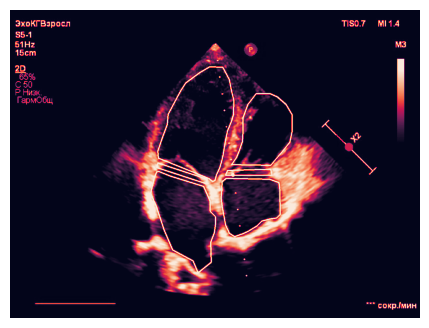

In [ ]:
test_id = np.random.randint(len(os.listdir('/content/datasets/train/images')))
test_yolo('/content', test_id)

### Training loop

In [ ]:
train_status = True
if train_status:
    shutil.rmtree('/content/runs/segment', ignore_errors=True)
    results = y_model.train(batch=8, device=device, data="data.yaml", epochs=60, imgsz=640)
    show_image(filename="/content/runs/segment/train/results.png", width=1000)

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=data.yaml, epochs=60, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

100%|██████████| 755k/755k [00:00<00:00, 23.7MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 112MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/train/labels... 124 images, 0 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:00<00:00, 1087.51it/s]

train: New cache created: /content/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/val/labels... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 657.06it/s]

val: New cache created: /content/datasets/val/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.84G      2.186      4.615        3.9      2.162         31        640: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         34        204      0.495      0.322      0.242      0.126      0.487      0.332      0.222      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.67G      1.538      2.915      2.096      1.581         30        640: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         34        204      0.258      0.521      0.335      0.216      0.254      0.528      0.328        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.81G      1.417      2.728      1.807      1.486         21        640: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

                   all         34        204      0.137      0.506       0.13     0.0869      0.137      0.496      0.129     0.0824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.73G      1.421      2.748      1.565      1.492         45        640: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         34        204      0.132        0.7      0.188      0.102        0.3       0.52       0.16     0.0734



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.72G      1.482      2.714      1.509      1.509         37        640: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

                   all         34        204      0.169      0.808      0.195     0.0891      0.158      0.643      0.155     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.79G      1.374      2.593      1.347      1.427         34        640: 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         34        204      0.444       0.48      0.384      0.215      0.428      0.462      0.335      0.183

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.66G      1.374      2.431      1.298       1.43         48        640: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

                   all         34        204      0.577      0.617      0.655      0.398      0.562      0.563      0.605      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.58G      1.335      2.452      1.302      1.442         42        640: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


                   all         34        204      0.894       0.63      0.745      0.464      0.878      0.616      0.672      0.361

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.65G      1.291      2.392      1.213      1.388         34        640: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         34        204      0.809      0.708      0.764      0.471      0.766      0.673       0.67      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.67G      1.321      2.432      1.148      1.389         40        640: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


                   all         34        204      0.802      0.752      0.802      0.518      0.754      0.713      0.719      0.419

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.89G      1.251      2.282      1.071      1.382         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         34        204      0.692      0.816      0.791      0.505      0.734       0.72       0.73      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.72G      1.304      2.312      1.073       1.39         42        640: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         34        204      0.747      0.836       0.81      0.529      0.731      0.753      0.744      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.73G      1.286      2.348     0.9703      1.362         62        640: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

                   all         34        204        0.7      0.734       0.79      0.486      0.755      0.694      0.738      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.68G      1.256      2.265     0.9861      1.365         44        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         34        204      0.676      0.755      0.788      0.504      0.676      0.698      0.733      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/60       4.7G      1.236      2.256     0.9528      1.338         58        640: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         34        204      0.773      0.799      0.843       0.51      0.678      0.719      0.712      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.75G      1.186      2.139     0.9411       1.31         38        640: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         34        204      0.698      0.831      0.814      0.523       0.71      0.766      0.753      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.79G      1.118      2.117     0.8824       1.28         41        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

                   all         34        204      0.786      0.772       0.82      0.524      0.745      0.731      0.742      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.61G      1.113      2.073     0.8534      1.296         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


                   all         34        204      0.837      0.832      0.873      0.551      0.805      0.796      0.807      0.487

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.79G      1.153      2.126     0.8886      1.317         53        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         34        204      0.789      0.844      0.853       0.55      0.795      0.757      0.772      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/60      4.67G      1.088      1.997     0.8033      1.255         56        640: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         34        204       0.85      0.828      0.873      0.565      0.807      0.784      0.793       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.74G      1.121      2.083     0.8248       1.29         28        640: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         34        204      0.827      0.916      0.883      0.564      0.865      0.769      0.799      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.76G      1.091      2.003     0.7899      1.241         50        640: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         34        204      0.805      0.873      0.846      0.555      0.748      0.784      0.763      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/60       4.8G      1.035       1.98     0.7541      1.235         68        640: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         34        204       0.86      0.827      0.884       0.58      0.746      0.822      0.787      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.82G      1.086      2.031     0.7653      1.253         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

                   all         34        204      0.818       0.86      0.866      0.563      0.735      0.796      0.759      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.78G       1.07      1.976     0.7142      1.234         41        640: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


                   all         34        204      0.839       0.85      0.882      0.586       0.85      0.742       0.77      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/60      4.61G      1.051      1.939     0.7171      1.229         55        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

                   all         34        204      0.838      0.854      0.872      0.575      0.816       0.77      0.788      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.69G     0.9979      1.894     0.7012       1.19         54        640: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         34        204      0.818       0.83      0.863      0.589      0.811       0.79      0.789      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.93G       0.98      1.812       0.65      1.155         46        640: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         34        204      0.789      0.891      0.873      0.592      0.844       0.79      0.836      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/60       4.7G     0.9993      1.773     0.6788      1.183         41        640: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         34        204      0.795      0.876      0.856      0.571      0.747      0.791      0.756      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.78G     0.9713      1.779     0.6806      1.187         44        640: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         34        204       0.85      0.835      0.878      0.595      0.891      0.779      0.821      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.66G      1.014      1.842     0.6537      1.206         53        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         34        204       0.84       0.82      0.877      0.594      0.731      0.828      0.786      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/60       4.7G     0.9789      1.824     0.6475      1.151         50        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         34        204      0.843      0.856      0.891      0.593      0.796      0.739      0.754       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.71G     0.9577      1.811     0.6502      1.193         46        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


                   all         34        204      0.856      0.837       0.88      0.589      0.789      0.749      0.767      0.496

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.73G     0.9565      1.859     0.6562      1.206         56        640: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

                   all         34        204      0.874      0.857      0.883      0.601      0.817      0.764      0.769      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.67G     0.9572      1.772     0.6157      1.139         51        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         34        204      0.888      0.837      0.882      0.605      0.846      0.779      0.808      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.71G     0.9384      1.736     0.6167      1.151         50        640: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

                   all         34        204      0.848      0.875      0.879      0.607       0.81       0.79      0.805      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.67G     0.9431       1.73     0.6231      1.164         35        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


                   all         34        204      0.847      0.876      0.888      0.606      0.825      0.815      0.823      0.526

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.69G     0.9183      1.687     0.6013      1.134         69        640: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         34        204      0.856      0.885       0.89      0.592      0.818      0.845      0.827      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.63G     0.9304       1.72     0.6314      1.161         38        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         34        204      0.832      0.891      0.876      0.596       0.83      0.799      0.801       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.74G     0.9046      1.613     0.5963       1.14         45        640: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

                   all         34        204      0.867      0.874      0.891      0.602       0.83      0.815      0.804      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.83G     0.9168      1.599     0.5871      1.129         66        640: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


                   all         34        204      0.896      0.855      0.895      0.611      0.865      0.816      0.825      0.529

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.74G     0.8958       1.57     0.5643      1.119         31        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

                   all         34        204      0.848      0.868      0.867      0.592      0.762      0.778      0.761      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/60       4.7G     0.8651      1.654     0.5649      1.128         39        640: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         34        204      0.871      0.875      0.884      0.609      0.807      0.809      0.795       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.63G     0.8739      1.606     0.5638      1.133         40        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         34        204      0.874      0.905      0.892      0.608       0.85      0.815      0.816      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.75G     0.8409      1.567     0.5568      1.113         39        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         34        204      0.889      0.881      0.904      0.604      0.849      0.815      0.811      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/60      4.69G     0.8616      1.606      0.552      1.149         39        640: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         34        204      0.886      0.895      0.903      0.599      0.829      0.823      0.829      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.64G     0.8208       1.49     0.5174      1.094         49        640: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         34        204      0.872      0.875      0.891      0.597      0.857      0.783      0.811      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/60      4.76G     0.8109      1.473     0.5222      1.064         51        640: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         34        204      0.863      0.889      0.875      0.611      0.841      0.774      0.802      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.79G     0.8154      1.535     0.5514      1.107         68        640: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         34        204      0.891       0.88      0.878       0.61      0.805      0.804        0.8      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/60      4.68G     0.8113      1.478     0.5162      1.072         81        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

                   all         34        204      0.865      0.868      0.877        0.6      0.822       0.79      0.795      0.522


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.58G     0.7531      1.431     0.4819      1.157         24        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         34        204      0.873      0.873      0.875      0.597       0.82      0.773      0.772      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.59G     0.7266      1.371     0.4461      1.087         24        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         34        204      0.892      0.875      0.886      0.596      0.833      0.794      0.789      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.58G     0.7689      1.363     0.4763      1.097         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

                   all         34        204      0.906      0.855      0.887      0.604      0.863      0.789      0.797      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/60       4.6G     0.7193      1.336      0.454      1.104         24        640: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         34        204      0.884      0.878      0.898      0.606      0.849      0.815      0.819      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.58G     0.7177      1.339     0.4522      1.105         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         34        204      0.896      0.875      0.903      0.612      0.852       0.83      0.825      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.58G     0.6787      1.258     0.4319      1.068         24        640: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         34        204      0.901       0.88      0.903       0.61      0.853      0.798       0.81      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.58G     0.6977      1.302     0.4393        1.1         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

                   all         34        204       0.91      0.857      0.893      0.612      0.841      0.789      0.793      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/60      4.58G     0.6611       1.23     0.4212       1.06         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


                   all         34        204      0.896      0.867      0.892       0.61      0.847      0.804      0.807       0.53

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.57G     0.6597      1.207     0.4085      1.061         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         34        204      0.891      0.857      0.883       0.61      0.846      0.804      0.807      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.58G      0.659      1.206     0.4191      1.072         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         34        204      0.903       0.86      0.888      0.617      0.851      0.804      0.807       0.53



60 epochs completed in 0.161 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27225858 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


                   all         34        204      0.894      0.875      0.903      0.611      0.845       0.83      0.825      0.538
                    LA         33         33       0.99          1      0.995      0.769      0.991          1      0.995      0.753
                    LV         34         34      0.962          1      0.995      0.798      0.962          1      0.995      0.794
                    RA         33         35      0.899      0.914      0.915      0.745      0.928      0.943      0.937      0.727
                    RV         34         36      0.986      0.944      0.986      0.742      0.986      0.944      0.986      0.664
                    MV         33         33      0.855      0.758      0.851      0.396      0.754      0.667      0.716      0.206
                    TV         33         33      0.672      0.636      0.677      0.219      0.448      0.424      0.323     0.0856
Speed: 0.2ms preprocess, 14.2ms inference, 0.0ms loss, 2.4ms postproc

In [ ]:
test_data = list(map(lambda x: os.path.join('/content/datasets/test/images', x), os.listdir('/content/datasets/test/images')))

In [ ]:
best_model = YOLO('/content/runs/segment/train/weights/best.pt')
results = best_model(test_data, conf=.25, iou=.5, save=True)


0: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
1: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
2: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 2 MVs, 1 TV, 34.3ms
3: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
4: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
5: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
6: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
7: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
8: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
9: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
10: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
11: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
12: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
13: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
14: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
15: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
16: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 34.3ms
Speed: 11.6ms preprocess, 34.3ms inference, 3.6ms postprocess per image a

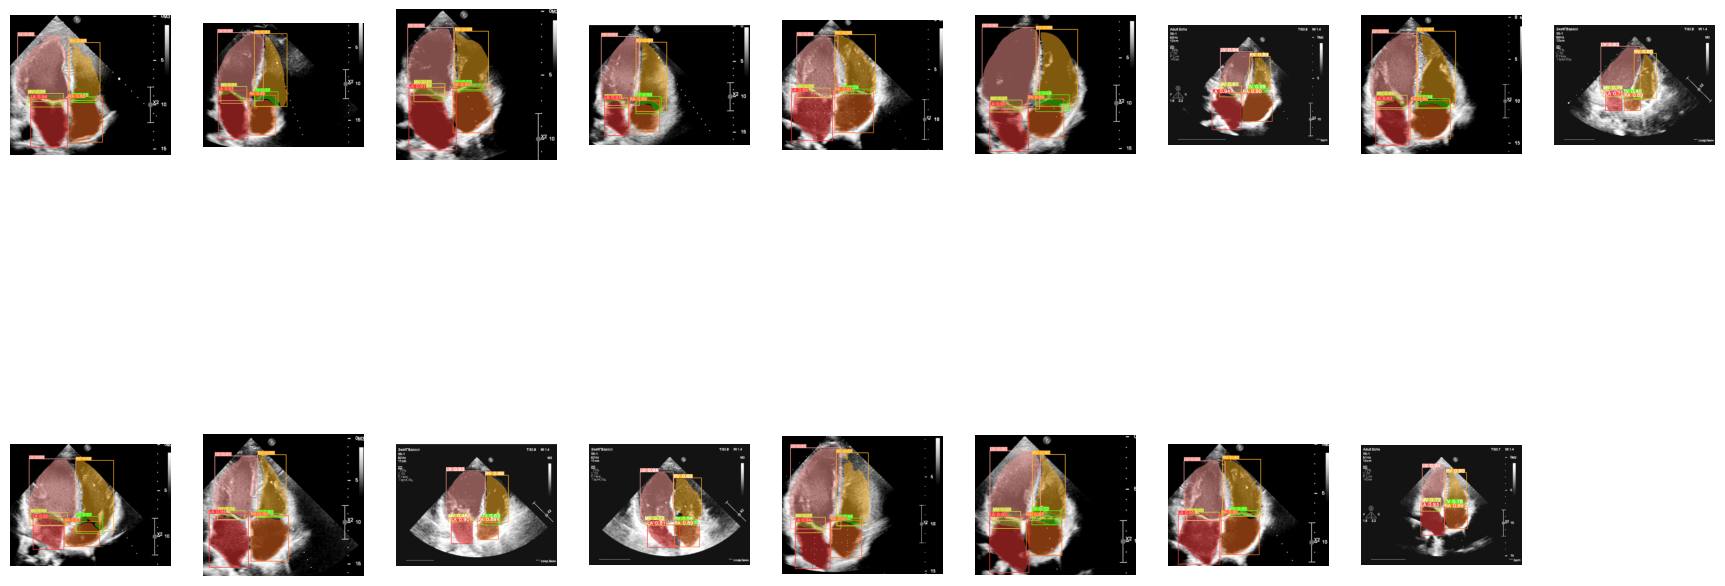

In [ ]:
res_dir = "/content/runs/segment/predict/"
files = os.listdir(res_dir)
fig = plt.figure(figsize=(22,10))
for i in range(len(files)):
    fig.add_subplot(2, math.ceil(len(files) / 2), i+1)
    look = Image.open(os.path.join(res_dir, files[i]))
    plt.axis("off")
    plt.imshow(look)
plt.show()